# mlarena Basic Usage

This notebook demonstrates basic usage of the `mlarena` library for machine learning model development and evaluation. With just a few lines of code, you can build a baseline model that 

* has comprehensive reporting
* with global and local explanation 
* easy deployment with mlflow
* can easily migrate to a different algorithm without disrupting deployment 


In [1]:
# Standard library imports
import multiprocessing
import os
import warnings

# Third party imports
import lightgbm as lgb
import pandas as pd
from sklearn.datasets import (
    fetch_california_housing,
    fetch_openml
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor
)   
from sklearn.model_selection import train_test_split
import mlflow
mlflow.autolog(disable=True)

from mlarena import PreProcessor, MLPipeline

# Configure parallel processing
# Only needed when running locally (not required on distributed platforms like Databricks)
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  # Use half of available cores to avoid overloading
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)

# Classification Demo

In [2]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)
X = PreProcessor.mlflow_input_prep(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
preprocessor = PreProcessor()
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Fit and Use the Fitted Model

You can fit and score with mlpipeline model like you would with an sklearn model. And `evaluate` methods offer comprehensive reports including below metrics and visuals.


| Category | Classification Metrics & Plots | Regression Metrics & Plots |
|-------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Metrics | **Evaluation Parameters**<br>• Threshold (classification cutoff)<br>• Beta (F-beta weight parameter)<br><br>**Core Performance Metrics**<br>• Accuracy (overall correct predictions)<br>• Precision (true positives / predicted positives)<br>• Recall (true positives / actual positives)<br>• F1 Score (harmonic mean of Precision & Recall)<br>• Fβ Score (weighted harmonic mean, if β ≠ 1)<br>• AUC (ranking quality)<br>• MCC (Matthews Correlation Coefficient)<br>• Log Loss (confidence-weighted error)<br><br>**Prediction Distribution**<br>• Positive Rate (fraction of positive predictions)<br>• Base Rate (actual positive class rate) | **Error Metrics**<br>• RMSE (Root Mean Squared Error)<br>• MAE (Mean Absolute Error)<br>• Median Absolute Error<br>• NRMSE (Normalized RMSE as % of) <ul style="margin-top:0;margin-bottom:0;"><li>mean</li><li>std</li><li>IQR</li></ul>• MAPE (Mean Absolute Percentage Error, excl. zeros)<br>• SMAPE (Symmetric Mean Absolute Percentage Error)<br><br>**Goodness of Fit**<br>• R² (Coefficient of Determination)<br>• Adjusted R²<br><br>**Improvement over Baseline**<br>• RMSE Improvement over Mean Baseline (%)<br>• RMSE Improvement over Median Baseline (%) |
| Plots | • Metrics vs Threshold (Precision, Recall, Fβ, with vertical threshold line)<br>• ROC Curve<br>• Confusion Matrix (with colored overlays) | • Residual analysis (residuals vs predicted, with 95% prediction interval)<br>• Prediction error plot (actual vs predicted, with perfect prediction line and error bands) |

<br>




=== Classification Model Evaluation ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.500    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.805    (Overall correct predictions)
• AUC:         0.876    (Ranking quality)
• Log Loss:    0.464    (Confidence-weighted error)
• Precision:   0.838    (True positives / Predicted positives)
• Recall:      0.703    (True positives / Actual positives)
• F1 Score:    0.765    (Harmonic mean of Precision & Recall)
• MCC:         0.608    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.378    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


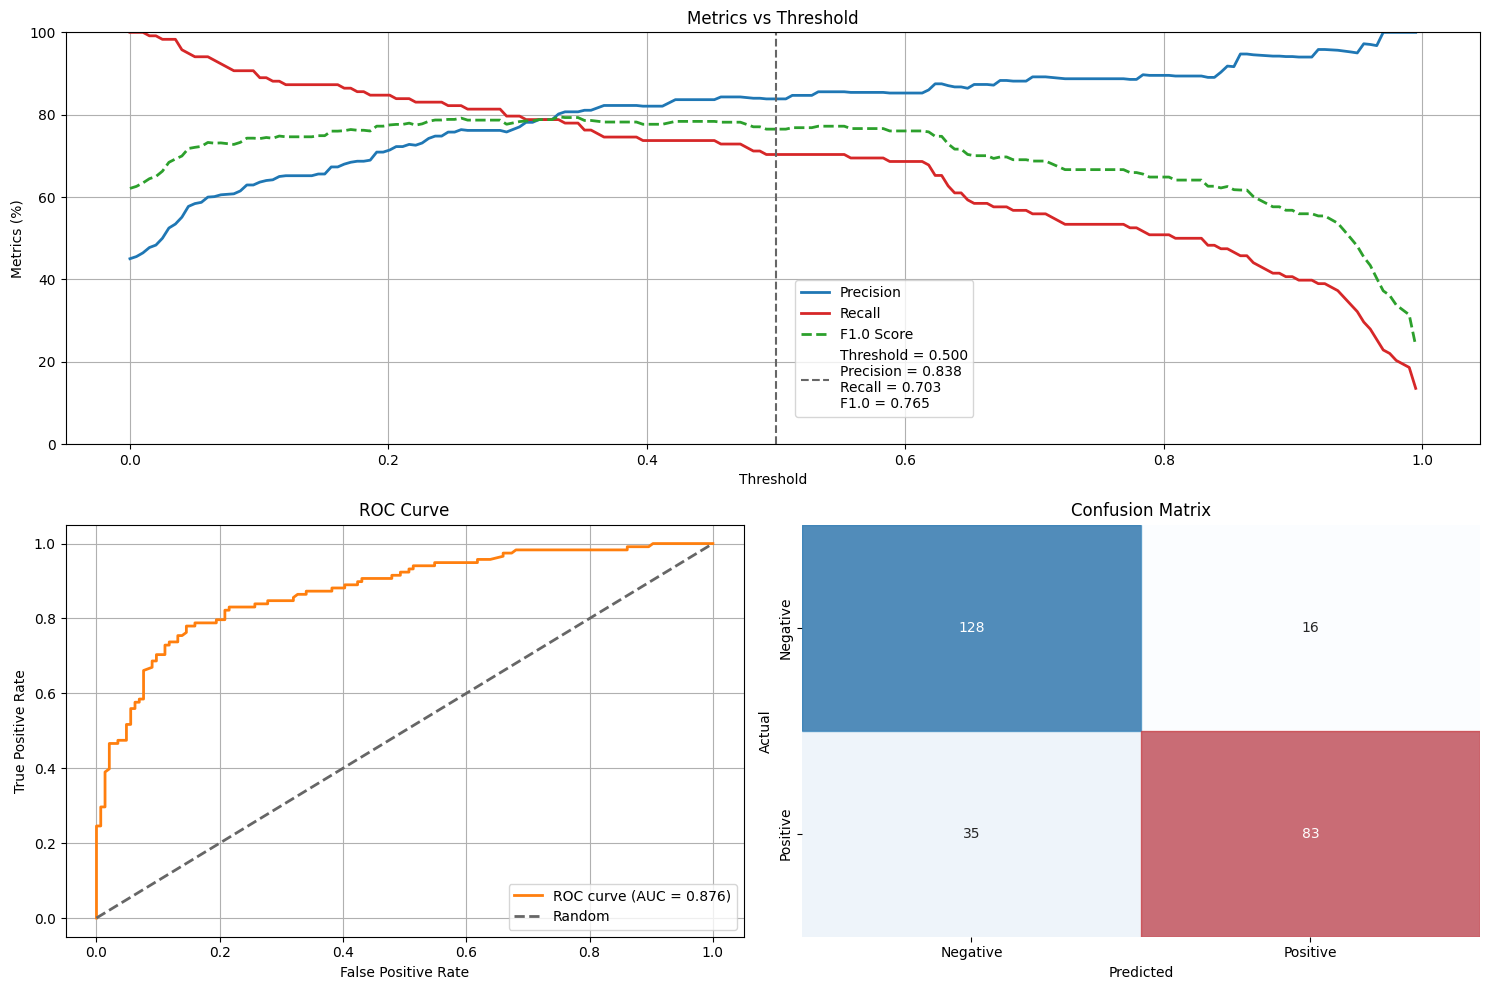

In [4]:
# define pipeline
mlpipeline = MLPipeline(
    model = lgb.LGBMClassifier(verbose=-1),
    preprocessor = PreProcessor()
    )
# fit pipeline
mlpipeline.fit(X_train,y_train)
# make prediction
y_pred = mlpipeline.predict(context = None, model_input = X_test)

# evaluate pipeline with metrics and visualization
results = mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)

## Model Explanation

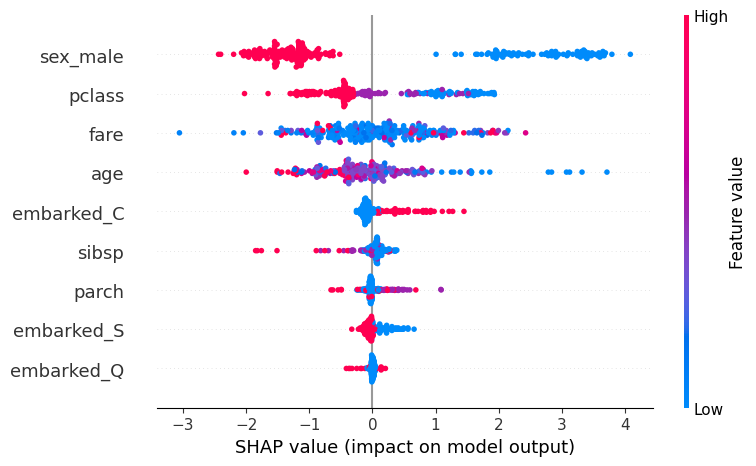

In [5]:
mlpipeline.explain_model(X_test)

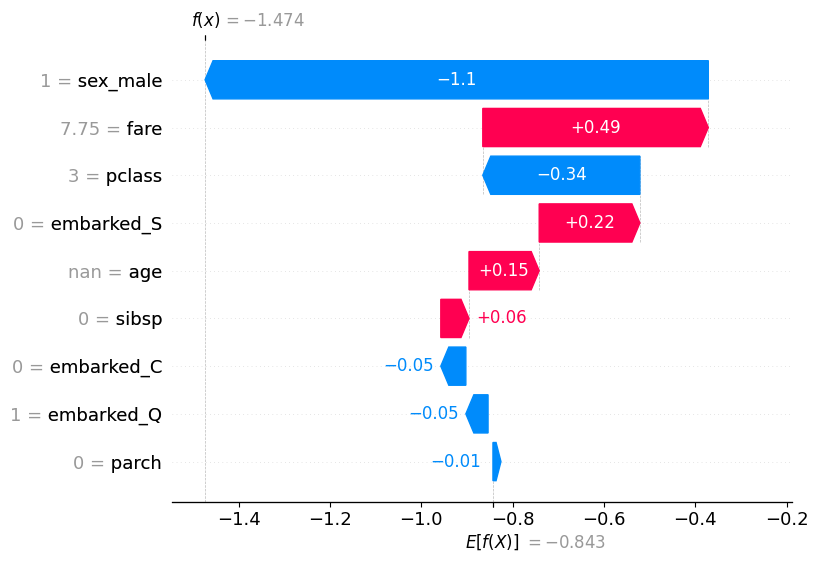

In [6]:
mlpipeline.explain_case(5)


## Swap Algorithm


=== Classification Model Evaluation ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.500    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.802    (Overall correct predictions)
• AUC:         0.855    (Ranking quality)
• Log Loss:    0.872    (Confidence-weighted error)
• Precision:   0.817    (True positives / Predicted positives)
• Recall:      0.720    (True positives / Actual positives)
• F1 Score:    0.766    (Harmonic mean of Precision & Recall)
• MCC:         0.598    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.397    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


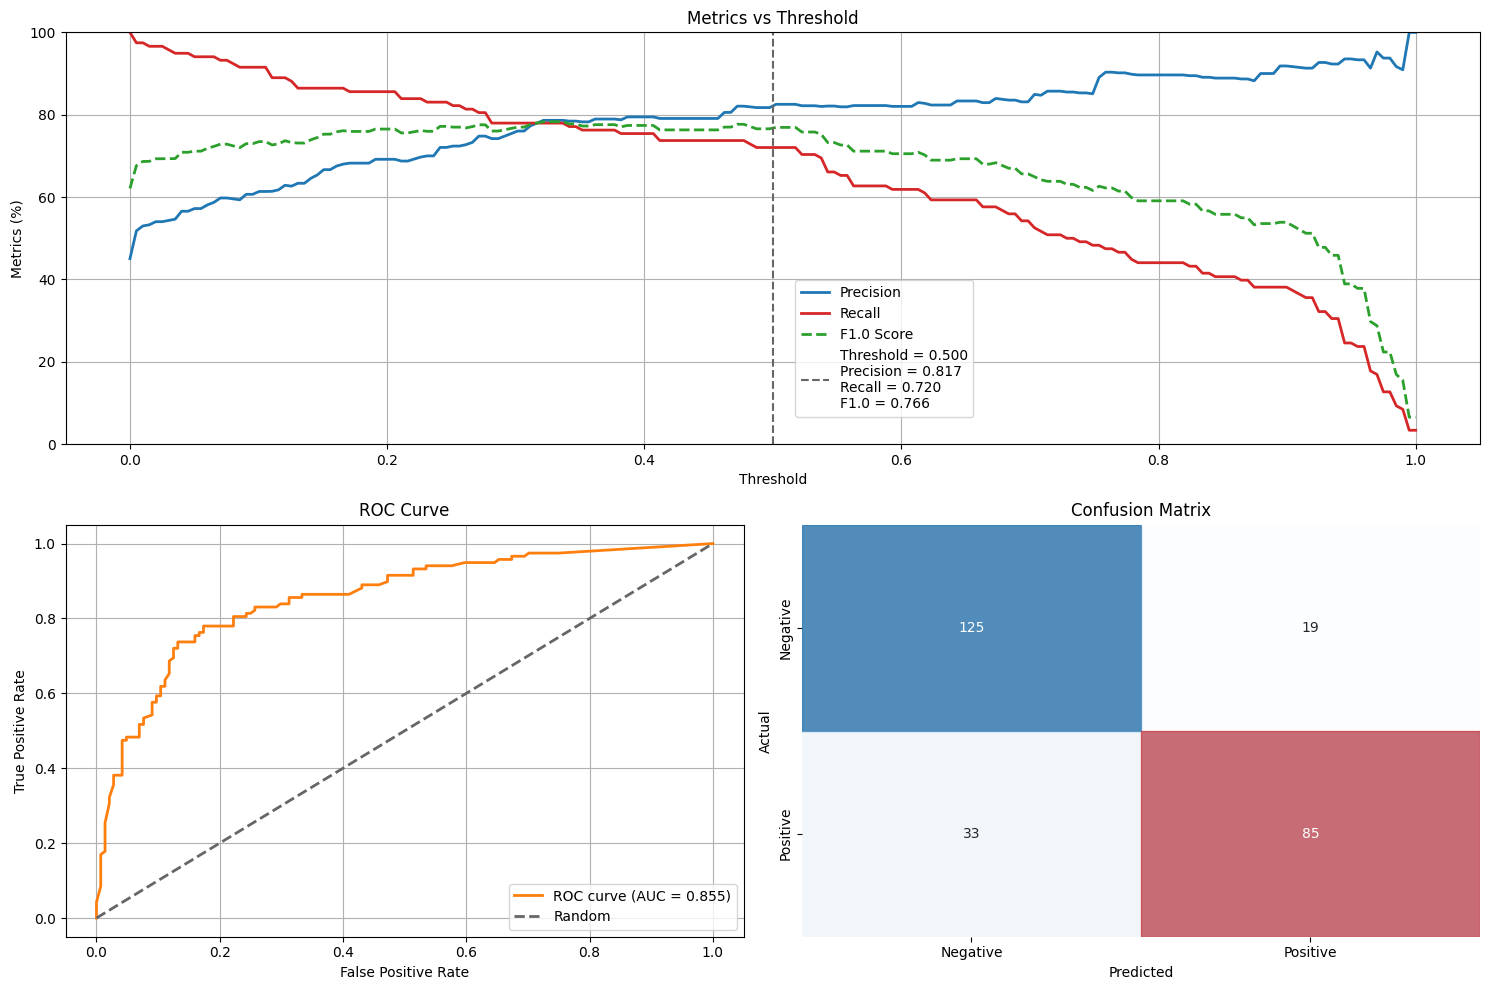

In [7]:
# Define the pipeline
mlpipeline_rf = MLPipeline(
    model = RandomForestClassifier(), # swap algorithms here
    preprocessor = PreProcessor()
)
# Fit the pipeline
mlpipeline_rf.fit(X_train,y_train)
# Evaluate on new data
rf_results = mlpipeline_rf.evaluate(X_test,y_test, verbose=True, visualize=True)

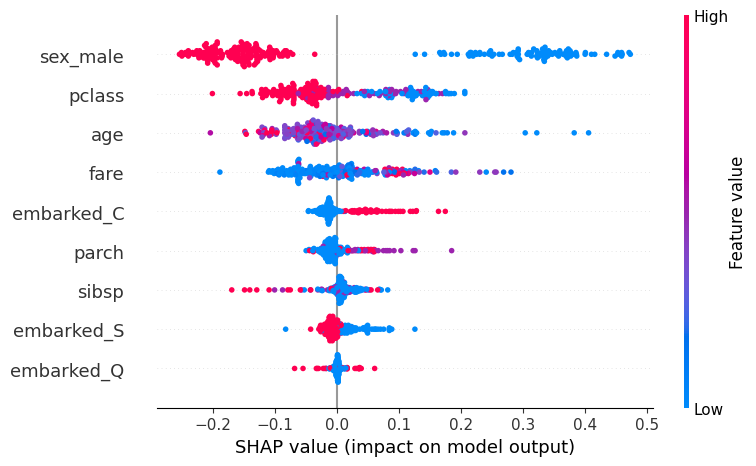

In [8]:
mlpipeline_rf.explain_model(X_test)

# Regression Demo

In [9]:
# Load data
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
X = PreProcessor.mlflow_input_prep(X)

y = california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Fit and Use the Fitted Model


=== Regression Model Evaluation ===

1. Error Metrics
----------------------------------------
• RMSE:         0.502      (Root Mean Squared Error)
• MAE:          0.327      (Mean Absolute Error)
• Median AE:    0.202      (Median Absolute Error)
• NRMSE Mean:   24.4%      (RMSE/mean)
• NRMSE Std:    43.9%      (RMSE/std)
• NRMSE IQR:    35.0%      (RMSE/IQR)
• MAPE:         18.9%      (Mean Abs % Error, excl. zeros)
• SMAPE:        16.5%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.807      (Coefficient of Determination)
• Adj. R²:      0.807      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      56.1%      (RMSE improvement)
• vs Median:    57.3%      (RMSE improvement)


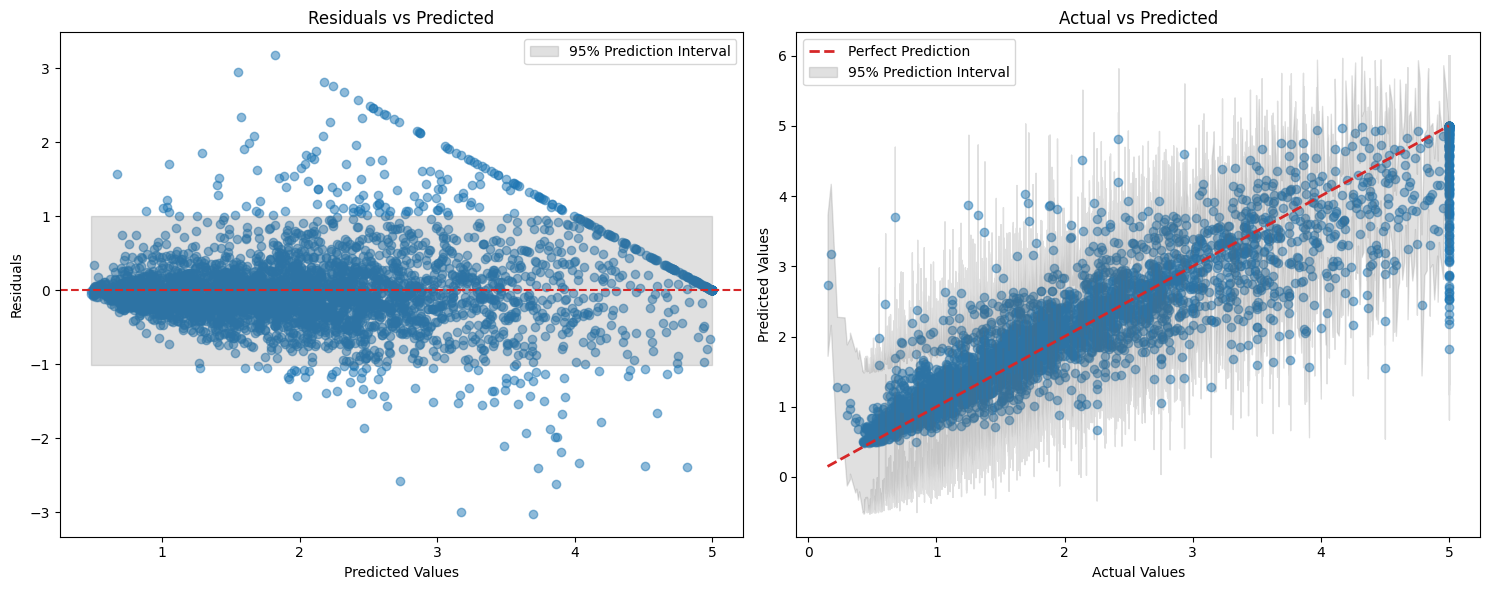

In [10]:
# Define the pipeline
mlpipeline = MLPipeline(
    model = RandomForestRegressor(),
    preprocessor = PreProcessor()
)
# Fit the pipeline
mlpipeline.fit(X_train,y_train)
# Evaluate on new data
results = mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)

## Swap Algorithm


=== Regression Model Evaluation ===

1. Error Metrics
----------------------------------------
• RMSE:         0.460      (Root Mean Squared Error)
• MAE:          0.305      (Mean Absolute Error)
• Median AE:    0.200      (Median Absolute Error)
• NRMSE Mean:   22.4%      (RMSE/mean)
• NRMSE Std:    40.2%      (RMSE/std)
• NRMSE IQR:    32.0%      (RMSE/IQR)
• MAPE:         17.7%      (Mean Abs % Error, excl. zeros)
• SMAPE:        15.9%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.839      (Coefficient of Determination)
• Adj. R²:      0.839      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      59.8%      (RMSE improvement)
• vs Median:    60.9%      (RMSE improvement)


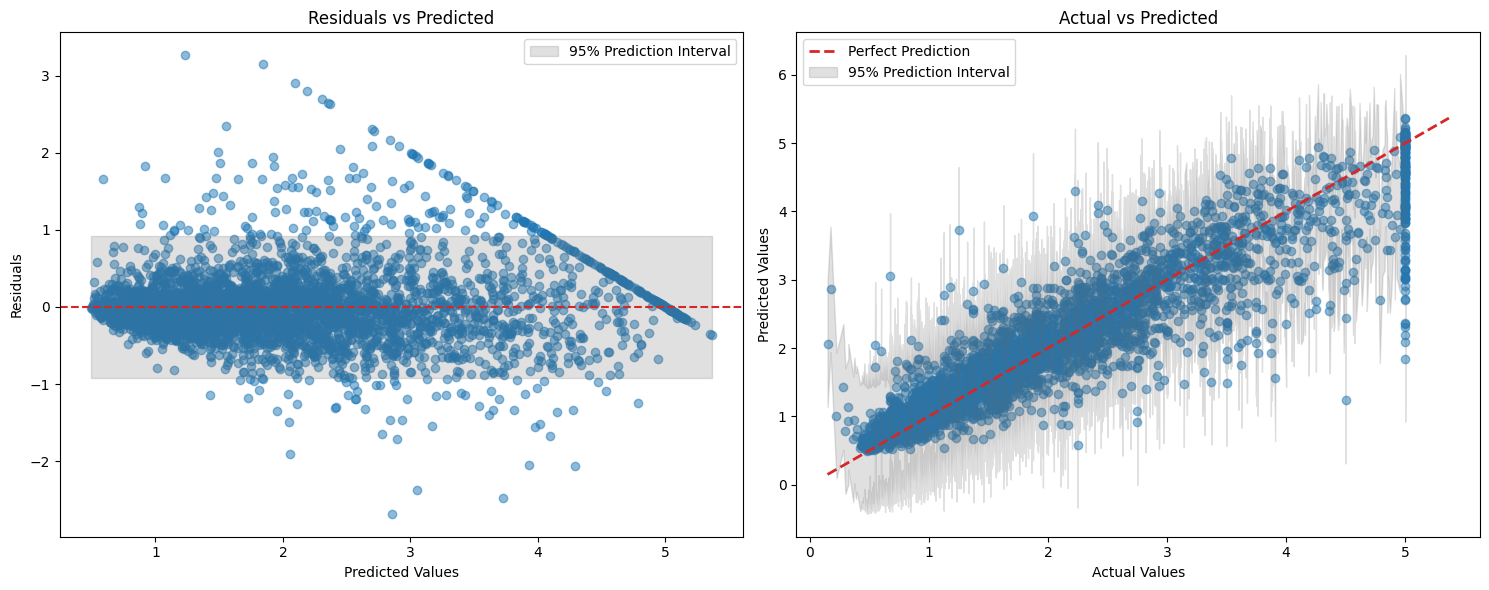

In [11]:
# Define the pipeline
mlpipeline_lgb = MLPipeline(
    model = lgb.LGBMRegressor(),
    preprocessor = PreProcessor()
)
# Fit the pipeline
mlpipeline_lgb.fit(X_train,y_train)
# Evaluate on new data
results = mlpipeline_lgb.evaluate(X_test,y_test, verbose=True, visualize=True)

# Log and Use the Logged Model

A key design feature of MLarena is that MLPipeline is built as a custom mlflow.pyfunc model. This means your entire workflow - the preprocessing logic and the trained model - is packaged into a single, reusable, and framework-agnostic artifact.

Because of this, your pipeline can be easily logged as an MLflow model, which benefits from automated experiment tracking and streamlined deployment within the MLflow ecosystem (more [in this article](https://medium.com/data-science/algorithm-agnostic-model-building-with-mlflow-b106a5a29535)).

To log your entire pipeline, simply set `log_model=True` when you evaluate it:

In [12]:
# Log the model to MLflow
# The warning about "mlarena not found in the public PyPI package index" is expected
# This happens because MLflow checks package availability against its cached PyPI index
# Since mlarena is a newer package (v0.1.9 released in April 2025), MLflow's index (last updated March 2025) doesn't recognize it yet
results = mlpipeline_lgb.evaluate(X_test, y_test, verbose=False, visualize=False, log_model=True)
model_info = results['model_info']

2025/07/01 22:39:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 22:39:38 INFO mlflow.pyfunc: Validating input example against model signature


When you do this, mlarena automatically handles the MLflow boilerplate for you:
* It starts an MLflow run.
* It logs all your model's hyperparameters and final evaluation metrics.
* It saves the complete MLPipeline object (preprocessor + model) as an artifact.
* It infers the model signature, which helps prevent errors when the model is used in production.

## Load and Utilize the Logged Model

The loaded model can be used to score new data, and has all the abilities of an MLPipeline instance. For example, it can produce comprehensive reporting and model explanation with a one-liner as demoed below. 

In [13]:
print(model_info.utc_time_created)
print(model_info.run_id)
print(model_info.model_uri)
print(model_info.mlflow_version)

2025-07-01 12:39:38.328064
42e2e08b433b4e4ca68a5c2f9a600a22
models:/m-b93a7ae2158d4b2ba4751d85c42a4421
3.1.1



=== Regression Model Evaluation ===

1. Error Metrics
----------------------------------------
• RMSE:         0.460      (Root Mean Squared Error)
• MAE:          0.305      (Mean Absolute Error)
• Median AE:    0.200      (Median Absolute Error)
• NRMSE Mean:   22.4%      (RMSE/mean)
• NRMSE Std:    40.2%      (RMSE/std)
• NRMSE IQR:    32.0%      (RMSE/IQR)
• MAPE:         17.7%      (Mean Abs % Error, excl. zeros)
• SMAPE:        15.9%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.839      (Coefficient of Determination)
• Adj. R²:      0.839      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      59.8%      (RMSE improvement)
• vs Median:    60.9%      (RMSE improvement)


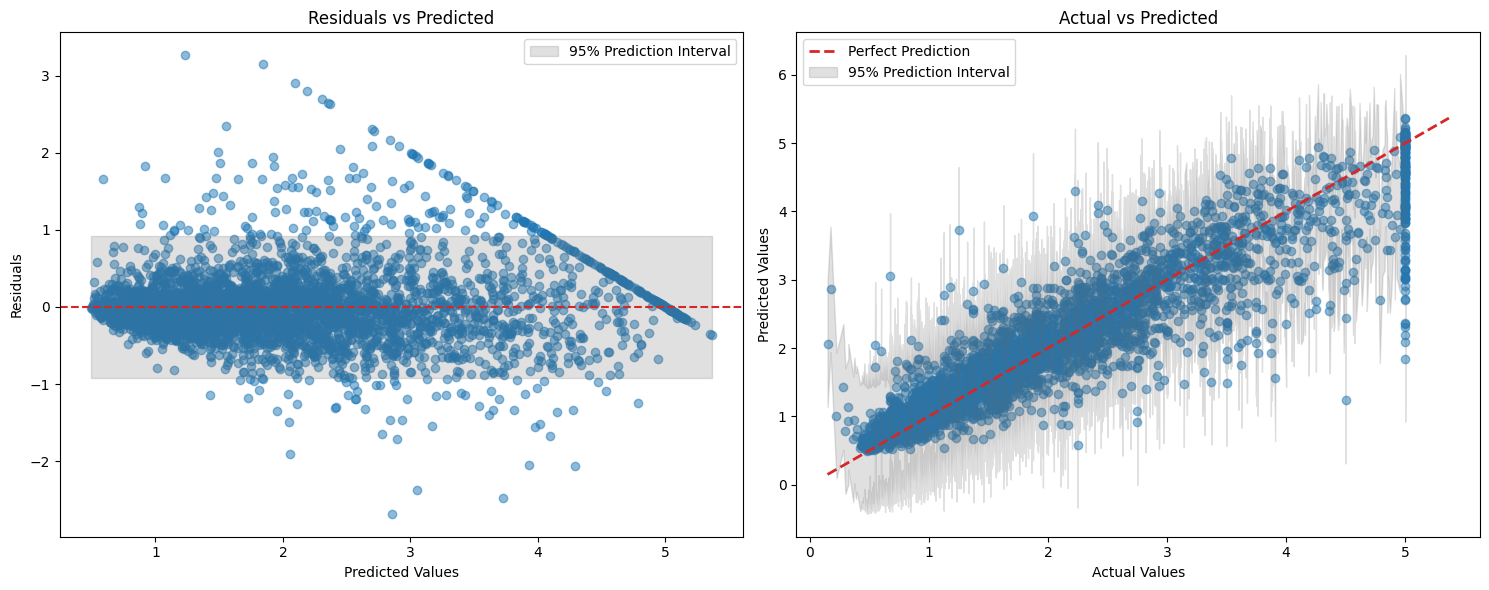

{'rmse': np.float64(0.45987687653485965),
 'mae': 0.3054582064419925,
 'median_ae': 0.1997964726465257,
 'nrmse_mean': np.float64(22.378403100492093),
 'nrmse_std': np.float64(40.173358745021844),
 'nrmse_iqr': np.float64(31.99699958496154),
 'mape': np.float64(17.71173699773407),
 'smape': np.float64(15.941806115483526),
 'r2': 0.8386101247143777,
 'adj_r2': 0.8385318893024959,
 'rmse_improvement_over_mean': np.float64(59.82664125497816),
 'rmse_improvement_over_median': np.float64(60.888132863709565),
 'n_train_samples': 16512,
 'n_features': 8,
 'sample_to_feature_ratio': 2064.0,
 'mape_excluded_count': np.int64(0)}

In [14]:
loaded_model = mlflow.pyfunc.load_model(model_uri=model_info.model_uri) 
unwrapped_model = loaded_model.unwrap_python_model()
unwrapped_model.evaluate(X_test, y_test, verbose=True, visualize=True)

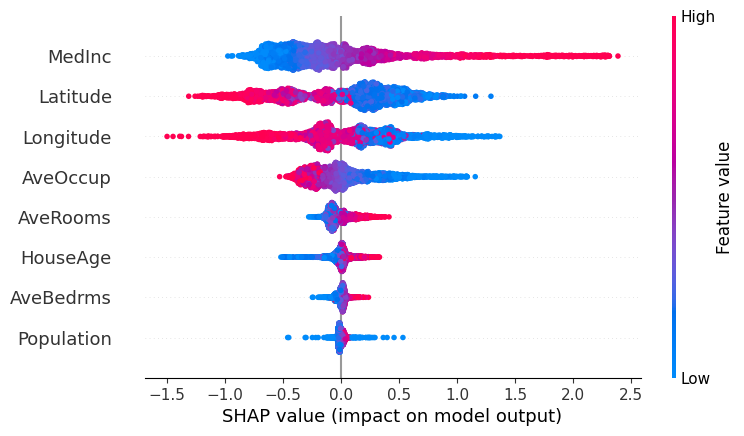

In [15]:
unwrapped_model.explain_model(X_test)

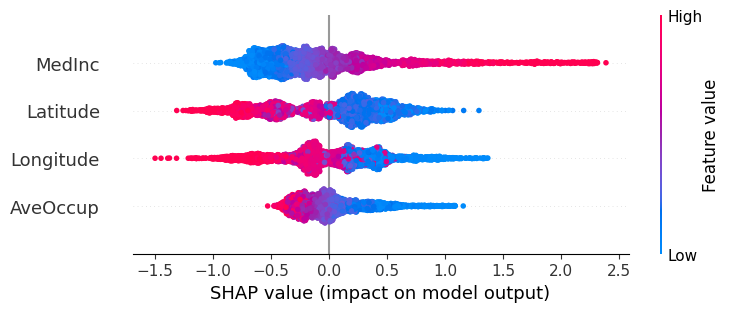

In [16]:
unwrapped_model.explain_model(X_test, max_features=4, group_remaining_features=False)

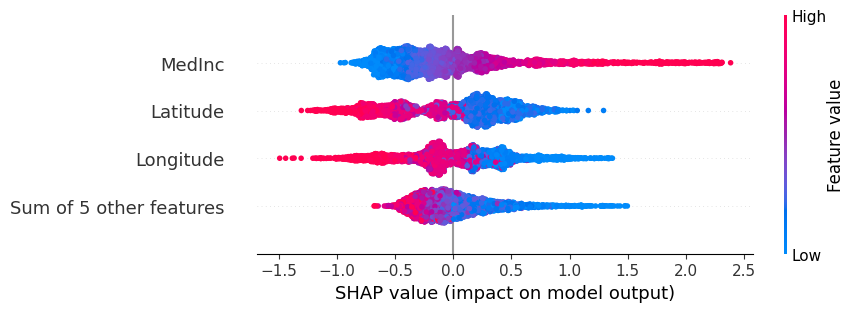

In [17]:
unwrapped_model.explain_model(X_test, max_features=4, group_remaining_features=True)

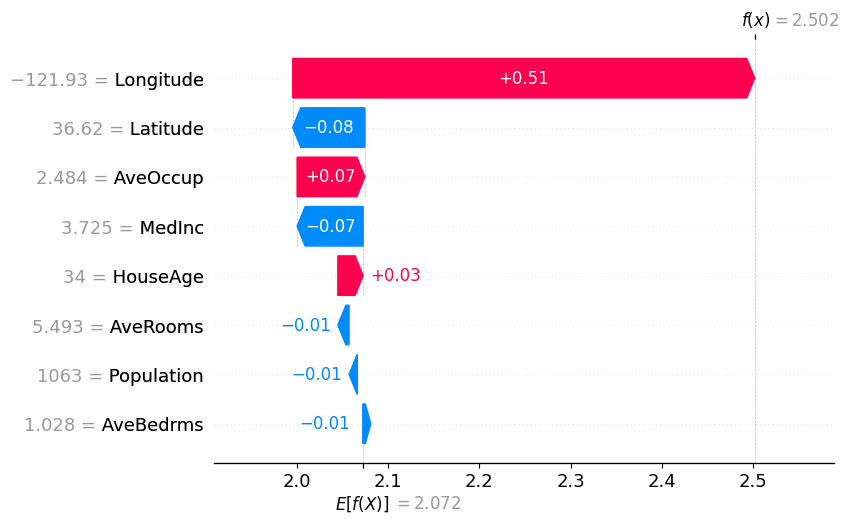

In [18]:
unwrapped_model.explain_case(5)

In [19]:
# call the trained preprocessor as the ml_pipeline attribute
X_test_transformed = unwrapped_model.preprocessor.transform(X_test)
X_test_transformed.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20046,-1.155085,-0.286324,-0.520686,-0.171746,-0.030301,0.067408,0.195100,0.285347
3024,-0.708659,0.110435,-0.165815,0.223472,0.121851,-0.036030,-0.235491,0.060975
15663,-0.210402,1.856173,-0.610765,0.205892,-0.102419,-0.149989,1.009478,-1.424870
20484,0.975113,-0.921138,0.305115,-0.176552,0.244979,0.030011,-0.637999,0.429943
9814,-0.081794,0.427842,0.024193,-0.158465,-0.319653,-0.052971,0.457199,-1.170581


In [20]:
# prediction with loaded model directly
X_test_prepped = PreProcessor.mlflow_input_prep(X_test)
loaded_model.predict(pd.DataFrame(X_test_prepped.head()))

array([0.58559011, 0.8555311 , 4.70605075, 2.33467468, 2.50219885])